In [2]:
%matplotlib widget
from matplotlib import pyplot as plt
from IPython.display import Audio
import scipy
import numpy as np
from IPython.display import HTML
HTML('''<style>.jupyter-matplotlib {background-color: #000;}.widget-label{color: #fff;}.jupyter-matplotlib-header{color: #000!important;}.jupyter-button {background-color: #333;color: #fff;}.cell-output-ipywidget-background {background-color:#000!important;}</style>''')

C:\Users\jezersek\AppData\Local\Temp\ipykernel_326172\2988207784.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, wave_full = scipy.io.wavfile.read('dataset/test_track.wav')


0

(0.0, 2131845.0)


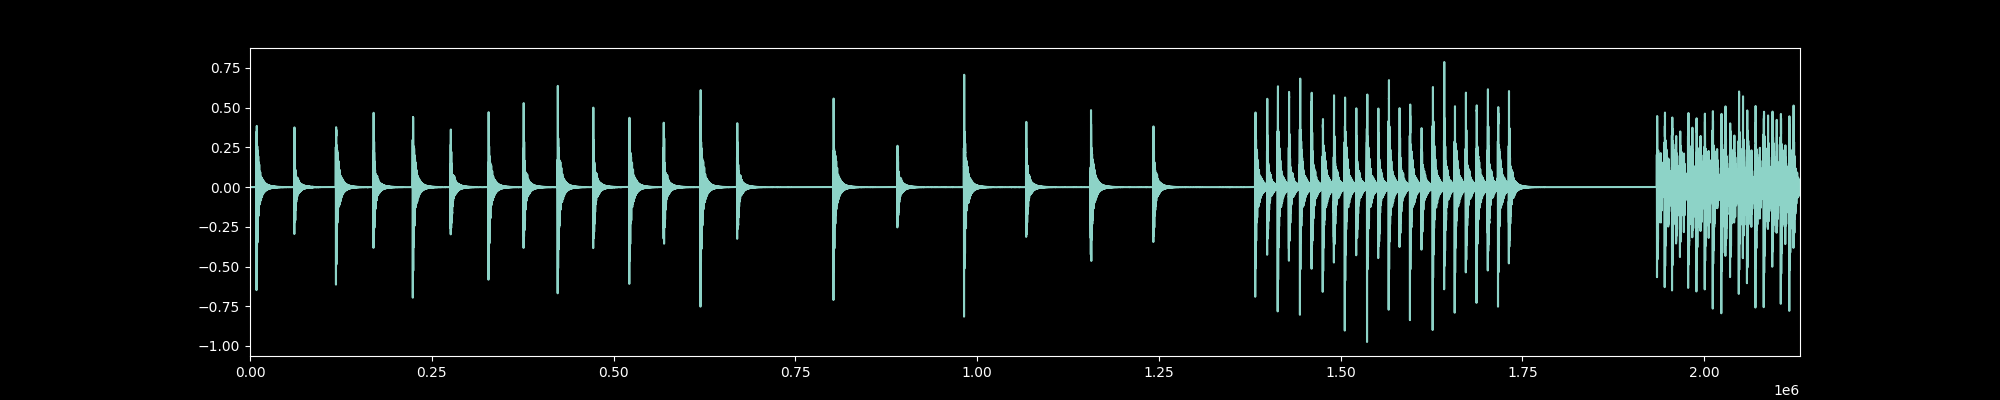

(1920035.8838709677, 2131845.0)


In [3]:
sample_rate, wave_full = scipy.io.wavfile.read('dataset/test_track.wav')
wave_full = np.mean(wave_full, axis=1) # convert stereo to mono

# plot the wave
fig, ax_wave = plt.subplots(figsize=(20, 4))
ax_wave.plot(wave_full)
ax_wave.set_xmargin(0)
ax_wave.callbacks.connect('xlim_changed', lambda ax: print(ax.get_xlim())) # type: ignore

In [5]:
wave = wave_full[int(ax_wave.get_xlim()[0]):int(ax_wave.get_xlim()[1])]
Audio(wave, rate=sample_rate)

# Beat detector

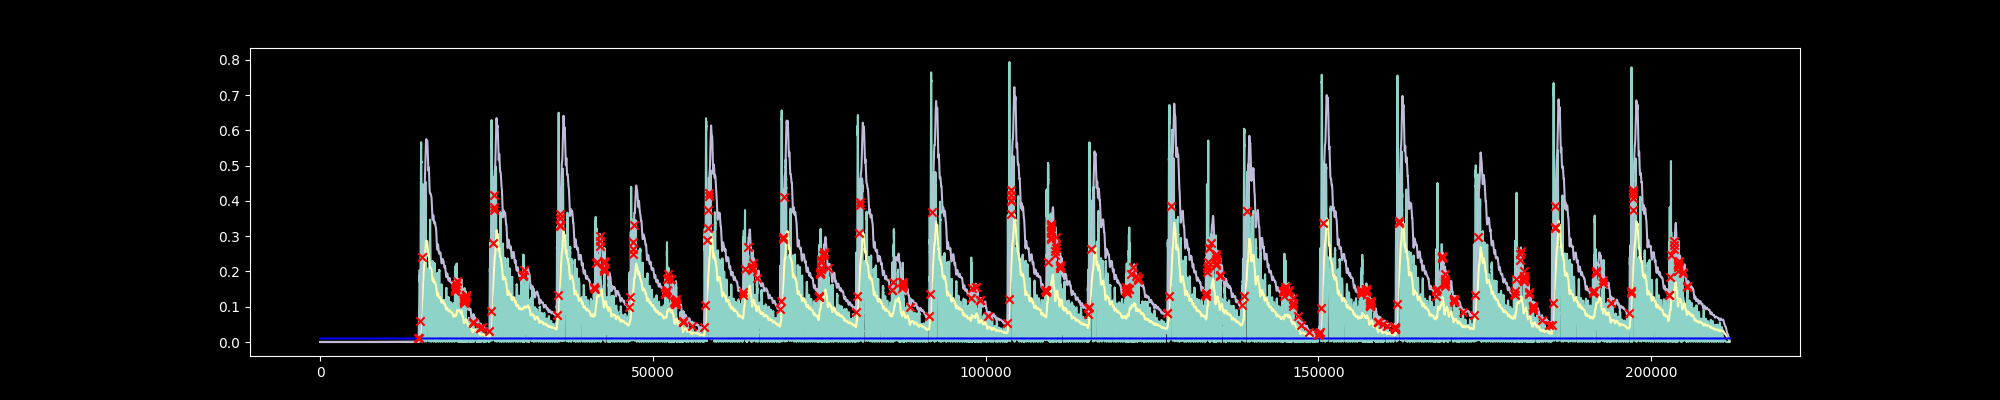

In [6]:
kernel_size = 1000
wave_abs = np.abs(wave)
wave_lopass = (np.convolve(wave_abs, [1]*kernel_size)/kernel_size)[:len(wave)]
min_threshold = np.ones_like(wave) * 0.01
dynamic_threshold = wave_lopass * 2
beats = np.where(wave_abs > np.maximum(dynamic_threshold, min_threshold), 1, 0)
beats = np.diff(beats)
beats = np.insert(beats, 0, 0)
beats = np.where(beats > 0, 1, 0)
beats_i = np.nonzero(beats)[0]
plt.figure(figsize=(20, 4))
plt.plot(wave_abs)
plt.plot(wave_lopass)
plt.plot(dynamic_threshold)
plt.plot(min_threshold, color='blue')
plt.scatter(beats_i, wave_abs[beats_i], color='red', marker='x', zorder=10)

In [21]:
sample_rate, click_wave = scipy.io.wavfile.read('samples/click.wav')
click_wave = np.mean(click_wave, axis=1) # convert stereo to mono
click_wave = click_wave[200:] # trim
click_wave = click_wave / np.max(np.abs(click_wave)) # normalize
click_wave = click_wave * 1 # reduce volume

Audio(click_wave, rate=sample_rate)

In [22]:
click_cool_down = sample_rate // 10
last_click_i = -click_cool_down
click_track = np.zeros(len(wave) + len(click_wave))
window = int(sample_rate / 1000 * 10) # 10 ms window
for i in np.nonzero(beats)[0]:
	if i - last_click_i > click_cool_down:
		last_click_i = i
		loudness = np.max(np.abs(wave[i-window:i+window]))*3
		click_track[i+window:i+len(click_wave)+window] += click_wave * loudness

Audio(click_track[:len(wave)] * 0.2 + wave * 0.8, rate=sample_rate)

# Beat detector with filtering

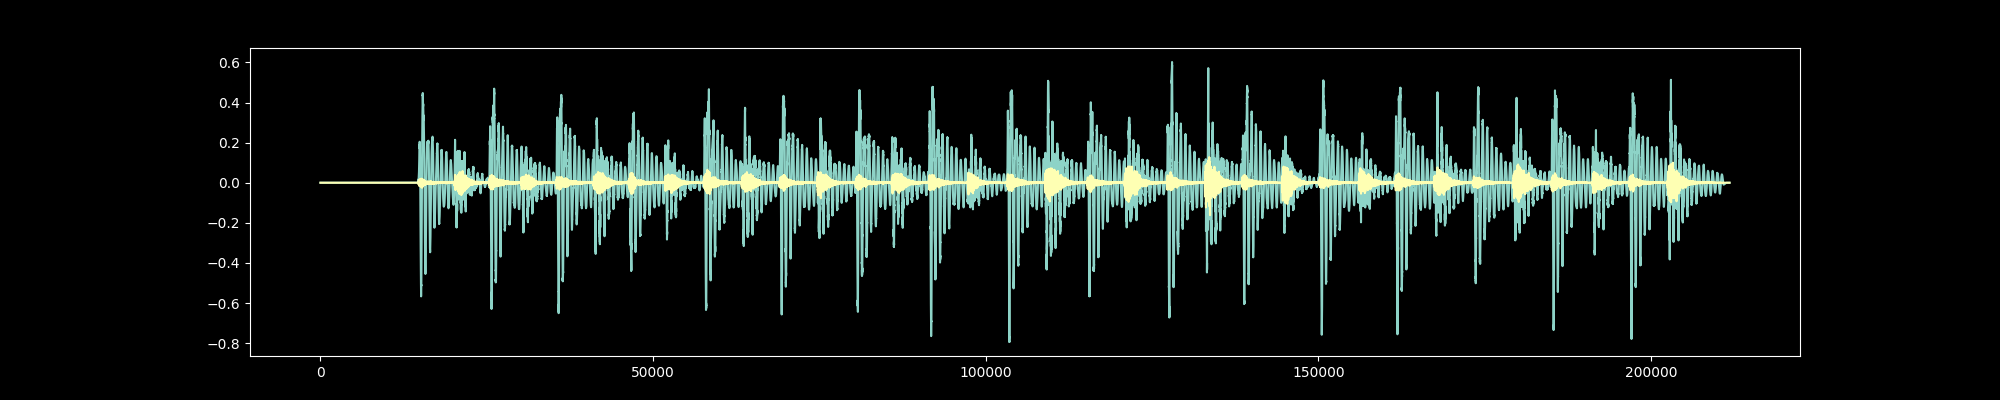

In [18]:
def high_pass(wave, cutoff_f=1000):
	order = 2

	highpass_iir = scipy.signal.iirfilter(
		order, [cutoff_f], btype='highpass',
		analog=False, ftype='butter', fs=sample_rate,
		output='ba'
	)

	return scipy.signal.filtfilt(*highpass_iir, wave)


plt.figure(figsize=(20, 4))
plt.plot(wave)
plt.plot(high_pass(wave, cutoff_f=500))


In [12]:
def find_onsets(
		wave: np.ndarray,
		min_threshold: float = 0.001, 
		dynamic_threshold_coeff: float = 2.0, 
		kernel_size: int = 2000,
		min_time_between_onsets: float = 0.05 # s
):
	wave_abs = np.abs(wave)
	wave_avg = (np.convolve(wave_abs, [1]*kernel_size)/kernel_size)[:len(wave)]
	dynamic_threshold = wave_avg * dynamic_threshold_coeff

	beats = np.where(wave_abs > np.maximum(dynamic_threshold, min_threshold), 1, 0)
	onsets: list[int] = []

	# remove beats that are too close to each other
	min_samples_between_onsets = int(min_time_between_onsets * sample_rate)
	for i in range(len(beats)):
		if beats[i] > 0:
			beats[i+1:i+min_samples_between_onsets] = 0

	# find onsets
	for i in range(len(beats)):
		if beats[i] > 0:
			onsets.append(i)

	return onsets, dynamic_threshold

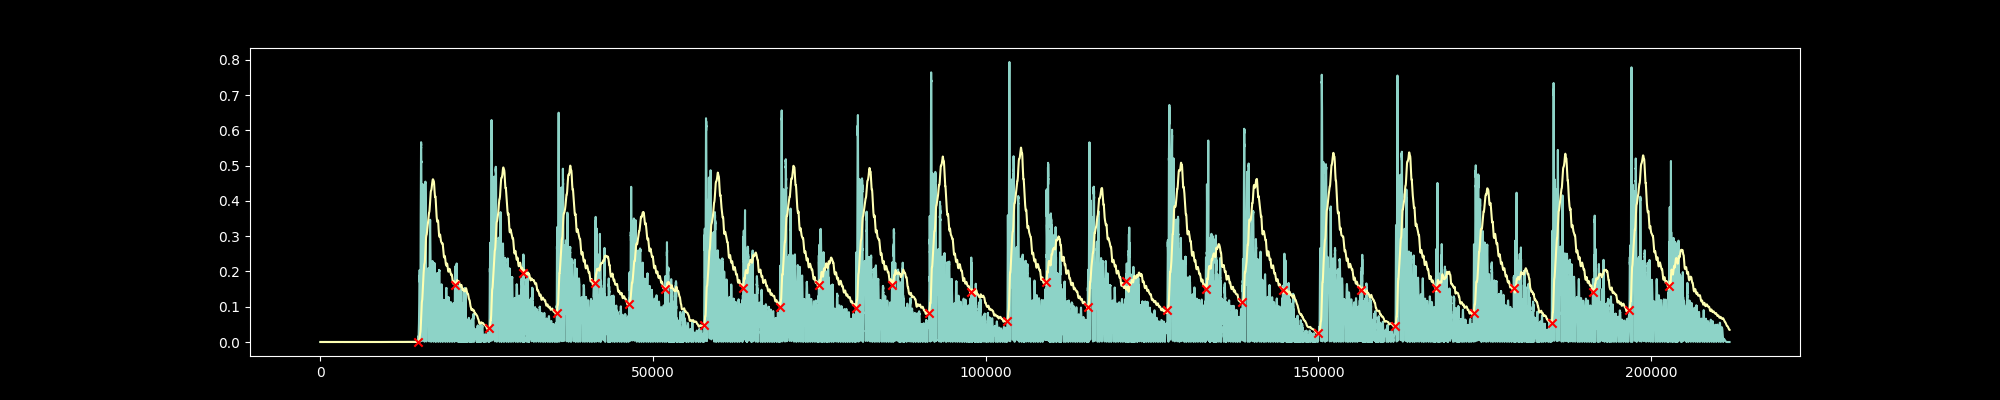

In [15]:
onsets, dynamic_threshold = find_onsets(wave)

plt.figure(figsize=(20, 4))
plt.plot(np.abs(wave))
plt.plot(dynamic_threshold)
plt.scatter(onsets, np.abs(wave[onsets]), color='red', marker='x', zorder=10)

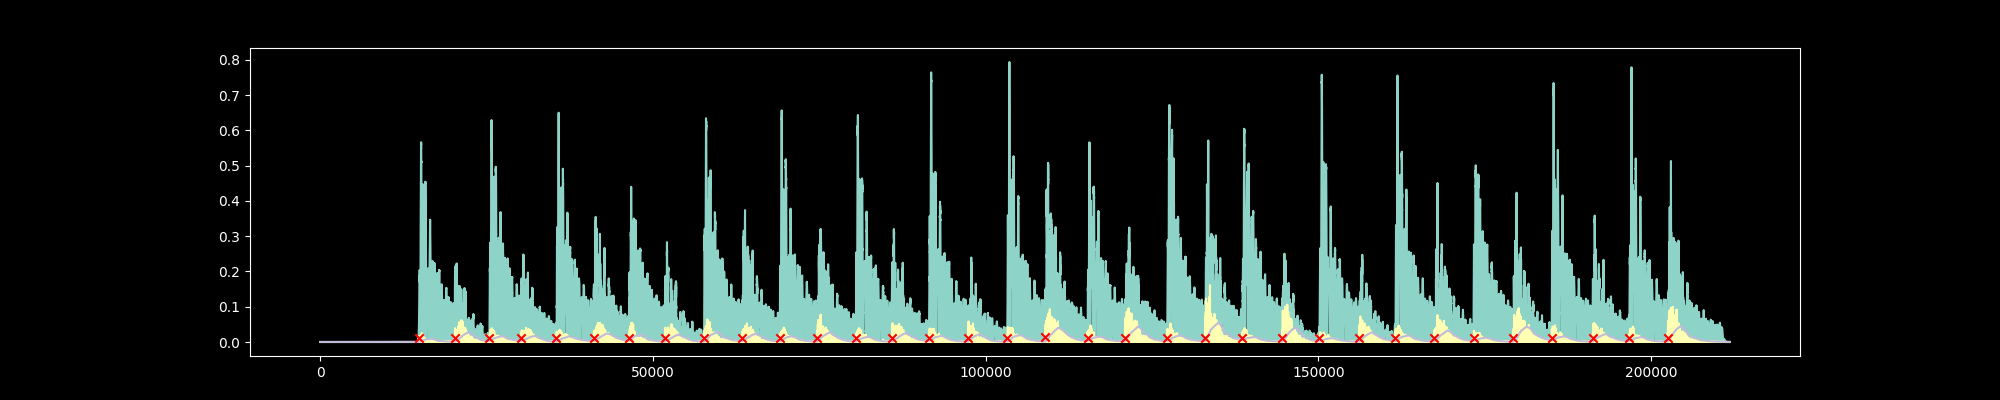

In [20]:
wave_high_pass = high_pass(wave, cutoff_f=500)

onsets, dynamic_threshold = find_onsets(wave_high_pass, min_threshold=0.01)

plt.figure(figsize=(20, 4))
plt.plot(np.abs(wave))
plt.plot(np.abs(wave_high_pass))
plt.plot(dynamic_threshold)
plt.scatter(onsets, np.abs(wave_high_pass[onsets]), color='red', marker='x', zorder=10)